In [ ]:
!unzip '/content/drive/MyDrive/metricLearning/post-processed.zip' -d dataset/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: dataset/post-processed/Michael_Goldrich/Michael_Goldrich_0001_0000.jpg  
  inflating: dataset/post-processed/Michael_Goldrich/Michael_Goldrich_0001_0001.jpg  
  inflating: dataset/post-processed/Michael_Goldrich/Michael_Goldrich_0002_0000.jpg  
  inflating: dataset/post-processed/Michael_Goldrich/Michael_Goldrich_0002_0001.jpg  
  inflating: dataset/post-processed/Michael_Goldrich/Michael_Goldrich_0002_0002.jpg  
   creating: dataset/post-processed/Michael_Hagee/
  inflating: dataset/post-processed/Michael_Hagee/Michael_Hagee_0001_0000.jpg  
  inflating: dataset/post-processed/Michael_Hagee/Michael_Hagee_0002_0000.jpg  
   creating: dataset/post-processed/Michael_Haneke/
  inflating: dataset/post-processed/Michael_Haneke/Michael_Haneke_0001_0000.jpg  
  inflating: dataset/post-processed/Michael_Haneke/Michael_Haneke_0001_0001.jpg  
  inflating: dataset/post-processed/Michael_Haneke/Michael_Haneke_0002_0000.jpg  
  

In [ ]:
# Lista os arquivos
from glob import glob
folders_names_to_run = glob("/content/dataset/post-processed/*/*", recursive = True)

In [ ]:
# Lê cada imagem, converte seu espaço de cores para RGB e armazena todas as imagens em um array
import cv2
import numpy as np

list_of_images = []
for folder in folders_names_to_run:
  img = cv2.imread(folder)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  list_of_images.append(img)
all_images = np.array(list_of_images)

In [ ]:
# Remove a parte inicial do caminho e adiciona o rótulo
from glob import glob
folders_names = glob("/content/dataset/post-processed/*/*", recursive = True)
y_labels_temp = []
for folder in (folders_names):
  y_labels_temp.append(folder.replace('/content/dataset/post-processed/',''))
y_labels_final = []
for i in (y_labels_temp):
  y_labels_final.append(i.split('/')[0])
print('Imagens no dataset =' + str(len(y_labels_final)))

Imagens no dataset =12000


In [ ]:
number_of_classes = len(list(set(y_labels_final)))
print('Número de classes = '+ str(number_of_classes))

Número de classes = 2996


In [ ]:
from collections import defaultdict
# Cria dicionário que mapeia as classes aos índices das imagens de treinamento correspondentes
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_labels_final):
    class_idx_to_train_idxs[y].append(y_train_idx)
class_idx_to_train_idxs
x_train = all_images

In [ ]:
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay

# Definição do número de classes e do tamanho das imagens
num_classes = 200
height_width = 112
#Fornece pares de imagens que serão utilizados no treinamento
class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        # Número de batches para a sequência
        self.num_batchs = num_batchs

    def __len__(self):
        # Retorna o tamanho da sequência
        return self.num_batchs

    def __getitem__(self, _idx):
        # Cria um array vazio de arrays com o formato das imagens
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        # O número de classes determina o número de pares de imagens retornadas
        for class_idx in range(num_classes):
            # Busca no dicionário a lista de índices de treinamento para a classe atual
            examples_for_class = class_idx_to_train_idxs[y_labels_final[class_idx]]
            # Escolhe um índice aleatório para a âncora e o positivo
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                # Garante que o índice positivo seja diferente do índice da âncora
                positive_idx = random.choice(examples_for_class)
            # Armazena os dados de treinamento nas posições apropriadas do array vazio
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x

In [ ]:
#O objetivo é determinar a similaridade entre um par de imagens que pertencem à mesma classe.
class EmbeddingModel(keras.Model):
    # sobrescreve o método train_step
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        # obtemos nossos âncoras e positivos de acordo com a estrutura que definimos anteriormente na classe AnchorPositivePairs
        # Aqui temos um lote dependendo do parâmetro do construtor
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # lotes para os pares de acordo com a categoria
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            #Aqui a similaridade é determinada entre ancoras e positivos,
            #com uma computação element-wise, basicamente produto ponto
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )
            # este parâmetro suaviza a distribuição entre a comparação das similaridades
            temperature = 0.2
            similarities /= temperature

            sparse_labels = tf.range(num_classes)
            # aplica-se a entropia cruzada categórica esparsa,
            # ela aplica um softmax para os logits, de forma a corresponder
            # Esta perda moverá os embeddings dos pares âncora/positivos juntos e moverá todos os outros pares separadamente.
            loss = self.compiled_loss(sparse_labels, similarities)

        # Calcula os gradientes e aplica via otimizador.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # atualiza e retorna as métricas (especificamente a métrica para o valor da perda).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
#CNN

# definimos a entrada da rede neural
inputs = layers.Input(shape=(height_width, height_width, 3))
# aplicamos as camadas convolucionais
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
# aplicamos a camada de pooling global para gerar o embedding
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
# normalizamos as embeddings para possibilitar o cálculo de produtos vetoriais
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

# aplicamos a classe personalizada de EmbeddingModel para realizar o mapeamento final
model = EmbeddingModel(inputs, embeddings)

1/1 [==============================] - 12s 12s/step - loss: 5.2964


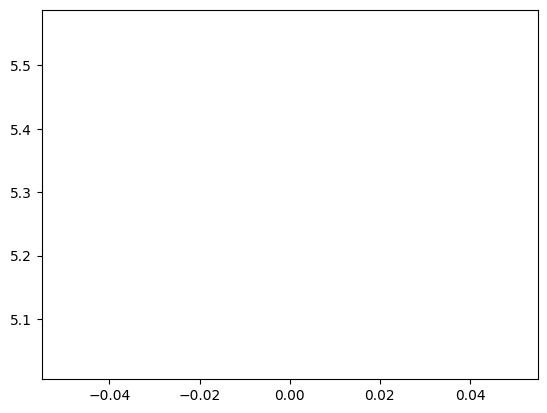

In [ ]:
import matplotlib.pyplot as plt
import random

#  Usando o otimizador Adagrad com uma taxa de aprendizagem e função de perda de entropia cruzada categórica esparsa.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
# O modelo é treinado usando a classe AnchorPositivePairs personalizada que retorna pares de imagens de uma mesma personalidade.
history = model.fit(AnchorPositivePairs(num_batchs=1), epochs=1)

# Plotando o gráfico de perda do modelo
plt.plot(history.history["loss"])
plt.show()

In [ ]:
from numpy.matrixlib.defmatrix import matrix
# Obtendo os vetores de descrição para as primeiras 100 imagens no conjunto de dados.
embeddings = model.predict(all_images[0:100,:,:,:])
# Obtem a matriz de scores de similaridade
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
# Ordena e retorna os exemplos mais similares para cada uma das 100 imagens
near_neighbours = np.argsort(gram_matrix.T)[:, -(100 + 1) :]


4/4 [==============================] - 0s 3ms/step


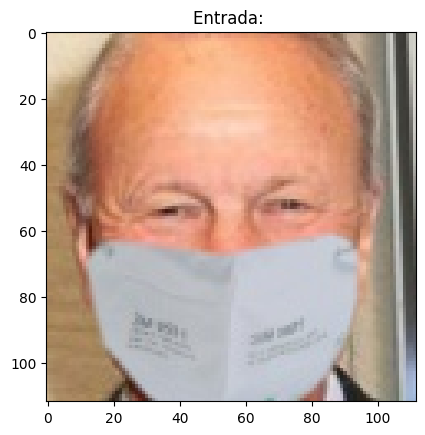

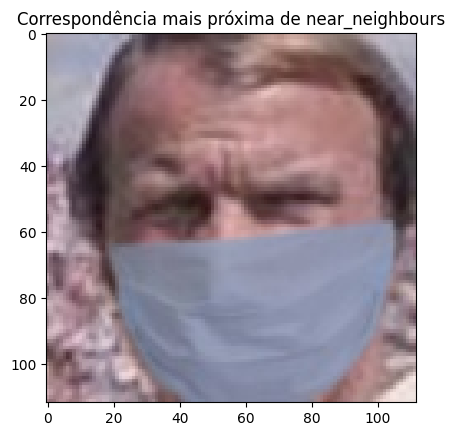

A etiqueta de entrada é: Albert_Costa
O rótulo vizinho é:  Albert_Costa


In [ ]:
# Vendo o que resulta como a imagem mais semelhante para a imagem no 30º indice:
plt.figure()
plt.imshow(all_images[near_neighbours[30][::-1][1]])
plt.title('Entrada: ')
plt.show()

plt.figure()
plt.title('Correspondência mais próxima de near_neighbours')
plt.imshow(all_images[near_neighbours[30][::-1][2]])
plt.show()
print('A etiqueta de entrada é:', y_labels_final[50])
print('O rótulo vizinho é: ', y_labels_final[50])

In [ ]:
#Criando o banco de dados: imagens e vetores de descrição
all_images[0:10,:,:,:].shape
y_labels_final[0:10]
embeddings[0:10,:]

array([[-0.47327197, -0.49791905, -0.05896409, -0.11004623,  0.66818565,
         0.05360929, -0.14890243,  0.2024481 ],
       [-0.42962834, -0.5032496 , -0.04850748, -0.11409035,  0.6871513 ,
         0.05424814, -0.13229588,  0.23273946],
       [-0.47327197, -0.49791905, -0.05896409, -0.11004623,  0.66818565,
         0.05360929, -0.14890243,  0.2024481 ],
       [-0.4742196 , -0.4877282 , -0.07979158, -0.10588767,  0.67501587,
         0.05971894, -0.1520319 ,  0.19321415],
       [-0.47327197, -0.49791905, -0.05896409, -0.11004623,  0.66818565,
         0.05360929, -0.14890243,  0.2024481 ],
       [ 0.23523575, -0.29656324,  0.48915333,  0.39641806, -0.21592656,
         0.46150717, -0.15217851, -0.42133683],
       [ 0.22514929, -0.28143302,  0.49599376,  0.41587564, -0.23499231,
         0.44572374, -0.14817928, -0.41867986],
       [ 0.23266086, -0.2962707 ,  0.5100349 ,  0.41328245, -0.23844582,
         0.41871604, -0.1338888 , -0.42077154],
       [ 0.21191968, -0.30017266

In [ ]:
# Colocando as 100 imagens em um dicionário que funcionará como nosso banco de dados
database = {}
for i in range(100):
  database.update({ i: {'y_labels_final': y_labels_final[i], 'all_images': all_images[i,:,:,:], 'embeddings': embeddings[i,:]}})
database

{0: {'y_labels_final': 'Ray_Bradbury',
  'all_images': array([[[129, 129, 129],
          [137, 137, 137],
          [146, 146, 146],
          ...,
          [ 72,  72,  72],
          [ 69,  69,  69],
          [ 48,  48,  48]],
  
         [[125, 125, 125],
          [119, 119, 119],
          [118, 118, 118],
          ...,
          [101, 101, 101],
          [100, 100, 100],
          [ 85,  85,  85]],
  
         [[112, 112, 112],
          [100, 100, 100],
          [ 89,  89,  89],
          ...,
          [139, 139, 139],
          [130, 130, 130],
          [121, 121, 121]],
  
         ...,
  
         [[ 38,  38,  38],
          [ 40,  40,  40],
          [ 39,  39,  39],
          ...,
          [244, 244, 244],
          [240, 240, 240],
          [230, 230, 230]],
  
         [[ 34,  34,  34],
          [ 40,  40,  40],
          [ 44,  44,  44],
          ...,
          [244, 244, 244],
          [246, 246, 246],
          [238, 238, 238]],
  
         [[ 25,  25,  25]

In [ ]:
from PIL import Image

# Adicionando o marcelinho
foo = Image.open('/content/drive/MyDrive/metricLearning/imagens/marcelinho_no_db.jpg')
foo = foo.resize((112,112),Image.ANTIALIAS)
marcelinho = np.array(foo)
marcelinho.shape
feature_description_marcelinho = model.predict(marcelinho.reshape(1,112,112,3))
label = 'marcelinho'
database.update({ len(database): {'y_labels_final': label, 'all_images': marcelinho, 'embeddings': feature_description_marcelinho}})
database
emb = database[0]['embeddings']
for i in range(1,len(database)):
  emb = np.vstack((emb,database[i]['embeddings']))
gram_matrix = np.einsum("ae,be->ab", emb, emb)
near_neighbours = np.argsort(gram_matrix.T)[:, -(100 + 2) :]
near_neighbours

1/1 [==============================] - 0s 108ms/step


array([[ 60,  59,  61, ...,   2,   4,   0],
       [ 60,  59,  61, ...,   4,   0,   1],
       [ 60,  59,  61, ...,   2,   4,   0],
       ...,
       [ 91,  29,  92, ...,  14,  99,  98],
       [ 29,  91,  33, ...,  93,  98,  99],
       [ 56,  58,  57, ...,  28,  32, 100]])

In [ ]:
# Fazendo inferência
foo = Image.open('/content/drive/MyDrive/metricLearning/imagens/marcelinho_na_inferencia.jpg')
foo = foo.resize((112,112),Image.ANTIALIAS)
marcelinho_inf = np.array(foo)
marcelinho_inf.shape
embed_inf = model.predict(marcelinho_inf.reshape(1,112,112,3))
embed_inf
emb = np.vstack((emb,embed_inf))
emb.shape
gram_matrix = np.einsum("ae,be->ab", emb, emb)
near_neighbours = np.argsort(gram_matrix.T)[:, -(100 + 2) :]
near_neighbours


1/1 [==============================] - 0s 18ms/step


array([[ 59,  56,  58, ...,   2,   4,   0],
       [ 61,  56,  58, ...,   4,   0,   1],
       [ 59,  56,  58, ...,   2,   4,   0],
       ...,
       [ 36,  37,  39, ..., 102, 101, 103],
       [ 36,  37,  39, ..., 102, 101, 103],
       [ 36,  37,  39, ..., 102, 101, 103]])

array([101, 100,  92,  63,  91,  62,  65,  64,  33,  29,  88,  32,  86,
        85,  83,  27,  30,  84,  28,  87,  31,  50,  46,   2,   4,   0,
        43,   8,   3,   6,   7,   1,  49,  48,  47,   5,  45,  44,  18,
        22,  19,  20,  21,  25,  26,  97,  71,  95,  96,  94,  70,  93,
        74,  72,  68,  73,  59,  61,  60,  69,  89,  90,  12,   9,  10,
        24,  82,  81,  11,  23,  17,  40,  41,  42,  14,  16,  67,  13,
        15,  66,  52,  51,  55,  54,  53,  78,  76,  80,  75,  79,  77,
        57,  58,  56,  98,  99,  34,  39,  37,  36,  38,  35])

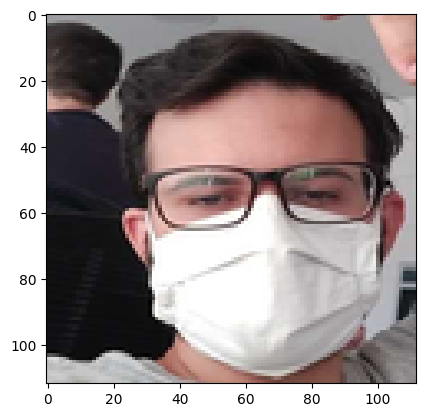

In [ ]:
plt.imshow(marcelinho_inf)
near_neighbours[101][::-1]

marcelinho


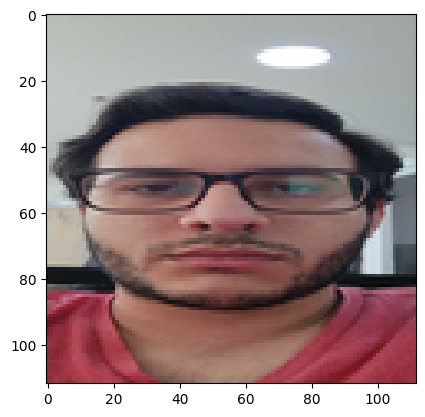

In [ ]:

plt.imshow(database[near_neighbours[101][::-1][1]]['all_images'])
print(database[near_neighbours[101][::-1][1]]['y_labels_final'])